**TOKENIZATION
**

In [5]:
project_path='/content/drive/MyDrive/CryptoFutureX'

In [4]:
!pip install  transformers

     |████████████████████████████████| 1.9MB 8.6MB/s 
     |████████████████████████████████| 890kB 51.2MB/s 
     |████████████████████████████████| 3.2MB 50.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=21907529d49d8f69cfeccab5447cd8528b4a225d5762d15144af691d56fedcee
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [108]:
import transformers
from transformers import DistilBertModel, DistilBertTokenizer, DistilBertConfig,AdamW, get_linear_schedule_with_warmup
import torch

import os
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [7]:
configuration = DistilBertConfig()
model = DistilBertModel(configuration)
configuration = model.config

In [8]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

rcParams['figure.figsize'] = 8, 6

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

device

device(type='cuda', index=0)

In [9]:
PATH='/content/drive/MyDrive/SentimentAnalysis-master/SentimentAnalysis-master/data/traindata_clean.csv'

In [10]:
df=pd.read_csv(PATH)
df.sample(10)

,tweet,target
420038,entity i sent you one yesterday that you never...,0
155377,"rain, sand and kids do not mix! i'm sooooo ove...",0
1506696,entity cheer up muffin,4
112617,fixing an old usb mouse gps that apparently ha...,0
207054,entity why r u crying?,0
483064,feeling sicc ughh dis weather is killing me smh!,0
270051,it is way too hot to be in the office,0
1471501,itz my b-day 2day!,4
1440825,entity entity -does random little dance- ta da...,4
1141195,"entity i'm on a boat aaaaand, it's goin' fast ...",4


In [12]:
PRETRAINED_MODEL_NAME = 'distilbert-base-uncased'

tokenizer = DistilBertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

In [14]:

# Finding the maximum token length

from tqdm import tqdm

token_lens = []

for t in tqdm(df.tweet):
    tokens = tokenizer.encode(t, max_length=512)
    token_lens.append(len(tokens))

100%|██████████| 1529862/1529862 [09:50<00:00, 2591.93it/s]


In [15]:
# Saving the token_lens list for further use

import pickle

with open(os.path.join(project_path, 'token_lens.txt'), 'wb') as file:
    pickle.dump(token_lens, file)

# Reading the list

# with open(os.path.join(project_path, 'token_lens.txt'), 'rb') as file:
#     token_lens = pickle.load(file)
# token_lens

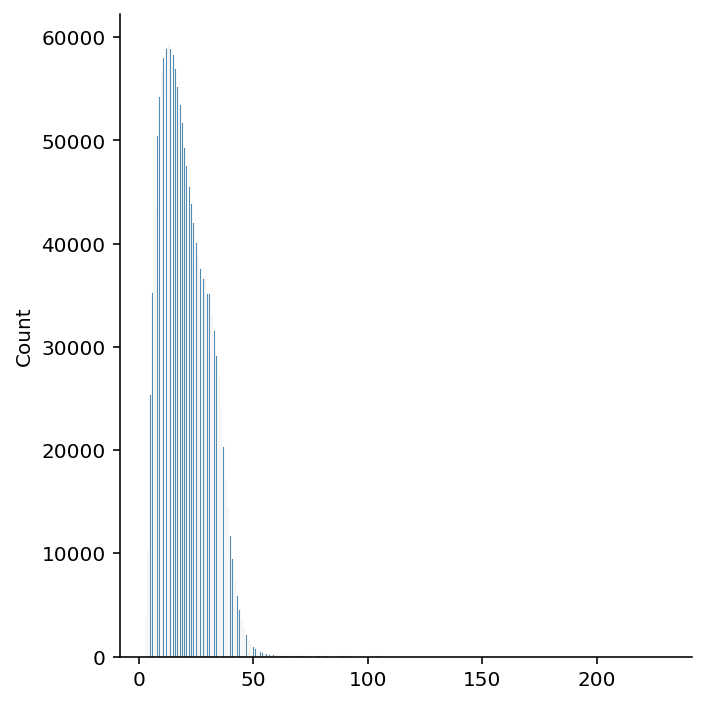

In [16]:
ax = sns.displot(token_lens)
plt.savefig(os.path.join(project_path, 'token_lens.jpg'))

In [17]:
MAX_LEN = 240

In [97]:
class TweetSentimentDataset(Dataset):
    def __init__(self, tweet, target, tokenizer, max_len):
        self.tweet = tweet
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.tweet)
    
    def __getitem__(self, item):
        tweets = self.tweet[item]
        targets= self.target[item]

        encoding = self.tokenizer.encode_plus(
            tweets,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'tweets': tweets,
            'target': torch.tensor(targets, dtype=torch.long),
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

In [98]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [99]:
print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

(1376875, 2)
(76494, 2)
(76493, 2)


In [115]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = TweetSentimentDataset(
        tweet=df.tweet.to_numpy(),
        target=df.target.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )

In [116]:

BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [102]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


dict_keys(['tweets', 'target', 'input_ids', 'attention_mask'])

In [62]:
DistilBert_model=DistilBertModel.from_pretrained(PRETRAINED_MODEL_NAME)

In [103]:
class TweetSentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(TweetSentimentClassifier, self).__init__()
        self.distil = DistilBertModel.from_pretrained(PRETRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.distil.config.hidden_size, n_classes)
    
    def forward(self, input_ids, attention_mask):
        o = self.distil(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooler_output = o['pooler_output']
        output = self.drop(pooler_output)
        return self.out(output)

In [104]:
# Creating a model instance
CLASS_NAMES = ['negative', 'positive']

model = TweetSentimentClassifier(len(CLASS_NAMES))
model = model.to(device)

In [105]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape)
print(attention_mask.shape)

torch.Size([16, 240])
torch.Size([16, 240])


In [106]:
F.softmax(model(input_ids, attention_mask), dim=1)

KeyError: ignored

In [109]:
# defining epoch ,optimizer,scheduler

EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [110]:
# Function to train model
def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples
):
    model = model.train()

    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        target = d['target'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, target)

        correct_predictions += torch.sum(preds == target)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double() / n_examples, np.mean(losses)

In [112]:

# Evaluating model function

def eval_model(
    model,
    data_loader,
    loss_fn,
    device,
    n_examples
):
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            target = d['target'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, target)

            correct_predictions += torch.sum(preds == target)
            losses.append(loss.item())
        
    return correct_predictions.double() / n_examples, np.mean(losses)

In [113]:

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


KeyError: ignored